# Introduction

Problem : A hotel  are about to make a new policy for recovering business after the pandemic. They want to make the best investment on the limited resource that they currently have. For that purpose they want to analyze their customer data to find the most profitable business direction

Metric : Costumer Lifetime Value is a business metric that calculate predicted total revenue of a customer for as long as their time as a customer. Knowing each of our customer value will make it easier for us to identify our most profitable customer. We can also use it to determine where we should invest in customer acquisition. Customer Lifetime Value also can be used as the basis for a customer retention program

The formulation to calculate customer lifetime values varies across business and industry but according to Webb, Cho and Legg (2022) one of the customer lifetime values formula that can be applied to hotel or other hospilality industry are RFM model. RFM model calculate lifetime value by assessing three aspect which is recency, frequency and monetary. Recency are calculating how recently the customer make a puchase. Frequency callculate the number of times customer make a purchase. Monetary calculate how much customer spend on a purchase. Ideal customer would have low recency but high in frequency and monetary.
Source : https://www.researchgate.net/publication/291696259_A_Proposed_Model_for_Customer_Lifetime_Value_in_Hotel_Segments

Objective : Build a clustering model to help create a customer segmentation based on customer lifetime value

Dataset : HCG test - Data Services Dept https://www.kaggle.com/datasets/hariwh0/hcg-test-data-services-dept

# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy import stats
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.metrics import calinski_harabasz_score, silhouette_score, silhouette_samples
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
import pickle

# Data Loading

In [ ]:
# Load dataset
df = pd.read_csv('bookings.csv')

In [ ]:
# Dataset overview
df.head()

,GuestID,Status,RoomGroupID,CreatedDate,ArrivalDate,DepartureDate,RoomPrice,Channel,RoomNo,Country,Adults,Children,TotalPayment
0,53801,O,1,2017-12-19,2018-09-09,2018-09-19,230.89,NaN,467.0,au,3,0,2309.93
1,37129,O,1,2017-12-20,2018-01-03,2018-01-05,170.15,other,467.0,us,0,0,340.94
2,37708,O,1,2017-12-20,2018-01-17,2018-01-20,176.81,NaN,647.0,jp,0,0,542.59
3,41515,O,1,2017-12-20,2018-02-18,2018-02-23,226.80,NaN,508.0,gb,1,0,1134.29
4,37390,O,1,2017-12-21,2018-01-11,2018-01-12,129.80,offline,529.0,cn,1,0,140.59


In [ ]:
# Dataset overview
df.tail()

,GuestID,Status,RoomGroupID,CreatedDate,ArrivalDate,DepartureDate,RoomPrice,Channel,RoomNo,Country,Adults,Children,TotalPayment
9995,131389,O,1,2020-01-10,2020-01-13,2020-01-19,217.08,offline,625.0,il,0,0,1306.40
9996,195075,O,1,2020-01-11,2020-01-14,2020-01-15,205.33,NaN,608.0,au,2,0,212.21
9997,37753,O,1,2020-01-11,2020-01-26,2020-01-31,219.33,other,617.0,in,1,0,1102.85
9998,144192,O,2,2020-01-12,2020-01-15,2020-01-16,248.16,NaN,456.0,ca,2,0,259.06
9999,134673,O,1,2020-01-13,2020-01-16,2020-01-17,192.38,other,767.0,cn,1,0,196.66


The dataset consist of 9 variables :
Variable | Definition
---|---
GuestID | Identification Number of Guest
Status | Status of Booking
RoomGroupID | Identification Number of Room Group
CreatedDate | Date of Creating Booking
ArrivalDate | Date of Arrival
DepartureDate | Date of Departure
RoomPrice | Price of Room per Day
Channel | Channel of Booking
RoomNo | Identification Number of Room
Country | Country of Guest
Adult | Number of Adults in Room
Children | Number of Children in Room
TotalPayments | Total payments from customer on a one booking period

In [ ]:
# Investigate each column assigned datat type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   GuestID        10000 non-null  int64  
 1   Status         10000 non-null  object 
 2   RoomGroupID    10000 non-null  int64  
 3   CreatedDate    10000 non-null  object 
 4   ArrivalDate    10000 non-null  object 
 5   DepartureDate  10000 non-null  object 
 6   RoomPrice      10000 non-null  float64
 7   Channel        6281 non-null   object 
 8   RoomNo         9790 non-null   float64
 9   Country        9518 non-null   object 
 10  Adults         10000 non-null  int64  
 11  Children       10000 non-null  int64  
 12  TotalPayment   10000 non-null  float64
dtypes: float64(3), int64(4), object(6)
memory usage: 1015.8+ KB


* Dataset consist of 10000 rows and 13 columns
* There are 6 numerical columns and 7 categorical columns
* There are missing values found in Channel, RoomNo and country columns
* CreatedDate, ArrivalDate and DepartedDate which are datetime variable are assigned as object so we need to convert it to datetime

## Column Adjustment

In [ ]:
# Convert CreatedDate, ArrivalDate and DepartureDate to datetime
df['CreatedDate'] = pd.to_datetime(df['CreatedDate'])
df['ArrivalDate'] = pd.to_datetime(df['ArrivalDate'])
df['DepartureDate'] = pd.to_datetime(df['DepartureDate'])

## Handling Missing Values

Missing values found in Channel, RoomNo and Country columns are all missing value completely at random so we will use imputation methods to handle it. Imputation for missing values in Channel columns will be replaced with other, for RoomNo columns will be replaced by -1 and lastly for country we will replaced it with otr

In [ ]:
# Imputing missing values on Channel, RoomNo and Country columns
df['Channel'].fillna('other', inplace=True)
df['RoomNo'].fillna(-1, inplace=True)
df['Country'].fillna('otr', inplace=True)

## RFM columns addition

Since we are going to analyze customer lifetime value using RFM Model, we are going to add variable based on each aspect which is recency, frequency, and monetary from the dataset.

In [ ]:
# Creating recency columns from today minus Guest last departure date
df_lastbook = df.groupby('GuestID', as_index=False)[['DepartureDate']].max()
today = pd.Timestamp.today().normalize()
df_lastbook['Recency'] = df_lastbook['DepartureDate'].apply(lambda x: (today - x).days)
df_lastbook.head()

,GuestID,DepartureDate,Recency
0,1,2019-09-29,1288
1,37,2019-06-02,1407
2,48,2019-05-04,1436
3,156,2019-08-10,1338
4,191,2019-09-01,1316


In [ ]:
# Creating recency score from quantile of recency
df_lastbook['R_score'] = np.ceil(df_lastbook['Recency'].rank(pct=True, ascending=False).mul(5)).astype(int)
df_lastbook.head()

,GuestID,DepartureDate,Recency,R_score
0,1,2019-09-29,1288,5
1,37,2019-06-02,1407,4
2,48,2019-05-04,1436,3
3,156,2019-08-10,1338,4
4,191,2019-09-01,1316,4


In [ ]:
# Creating frequency of staying from the number of each guest arrival date
df_stay = df.groupby('GuestID', as_index=False)[['ArrivalDate']].count()
df_stay.columns = ['GuestID', 'Frequency']
df_stay.head()

,GuestID,Frequency
0,1,1
1,37,2
2,48,4
3,156,2
4,191,2


In [ ]:
# Creating frequency score from quantile of frequency
df_stay['F_score'] = np.ceil(df_stay['Frequency'].rank(method='dense',pct=True).mul(5)).astype(int)
df_stay.head()

,GuestID,Frequency,F_score
0,1,1,1
1,37,2,1
2,48,4,2
3,156,2,1
4,191,2,1


In [ ]:
# Creating monetary value of customer from the average of payments amount of each guest
df_sum = df.groupby('GuestID', as_index=False)[['TotalPayment']].mean()
df_sum.columns = ['GuestID', 'Monetary']
df_sum.head()

,GuestID,Monetary
0,1,1337.890
1,37,139.220
2,48,643.150
3,156,699.300
4,191,468.775


In [ ]:
# Creating monetary score from quantile of monetary
df_sum['M_score'] = np.ceil(df_sum['Monetary'].rank(pct=True).mul(5)).astype(int)
df_sum.head()

,GuestID,Monetary,M_score
0,1,1337.890,5
1,37,139.220,1
2,48,643.150,4
3,156,699.300,4
4,191,468.775,3


## Merge to main dataframe

In [ ]:
# Merge recency dataframe with main dataframe
df_r = pd.merge(df,df_lastbook[['GuestID', 'Recency', 'R_score']], on='GuestID', how='left')
df_r.head()

,GuestID,Status,RoomGroupID,CreatedDate,ArrivalDate,DepartureDate,RoomPrice,Channel,RoomNo,Country,Adults,Children,TotalPayment,Recency,R_score
0,53801,O,1,2017-12-19,2018-09-09,2018-09-19,230.89,other,467.0,au,3,0,2309.93,1663,2
1,37129,O,1,2017-12-20,2018-01-03,2018-01-05,170.15,other,467.0,us,0,0,340.94,1726,2
2,37708,O,1,2017-12-20,2018-01-17,2018-01-20,176.81,other,647.0,jp,0,0,542.59,1905,1
3,41515,O,1,2017-12-20,2018-02-18,2018-02-23,226.80,other,508.0,gb,1,0,1134.29,1871,1
4,37390,O,1,2017-12-21,2018-01-11,2018-01-12,129.80,offline,529.0,cn,1,0,140.59,1913,1


In [ ]:
# Merge frequency dataframe with main dataframe
df_rf = pd.merge(df_r,df_stay[['GuestID', 'Frequency', 'F_score']], on='GuestID', how='left')
df_rf.head()

,GuestID,Status,RoomGroupID,CreatedDate,ArrivalDate,DepartureDate,RoomPrice,Channel,RoomNo,Country,Adults,Children,TotalPayment,Recency,R_score,Frequency,F_score
0,53801,O,1,2017-12-19,2018-09-09,2018-09-19,230.89,other,467.0,au,3,0,2309.93,1663,2,1,1
1,37129,O,1,2017-12-20,2018-01-03,2018-01-05,170.15,other,467.0,us,0,0,340.94,1726,2,2,1
2,37708,O,1,2017-12-20,2018-01-17,2018-01-20,176.81,other,647.0,jp,0,0,542.59,1905,1,1,1
3,41515,O,1,2017-12-20,2018-02-18,2018-02-23,226.80,other,508.0,gb,1,0,1134.29,1871,1,1,1
4,37390,O,1,2017-12-21,2018-01-11,2018-01-12,129.80,offline,529.0,cn,1,0,140.59,1913,1,1,1


In [ ]:
# Merge monetary dataframe with main dataframe
df_rfm = pd.merge(df_rf,df_sum[['GuestID', 'Monetary', 'M_score']], on='GuestID', how='left')
df_rfm.head()

,GuestID,Status,RoomGroupID,CreatedDate,ArrivalDate,DepartureDate,RoomPrice,Channel,RoomNo,Country,Adults,Children,TotalPayment,Recency,R_score,Frequency,F_score,Monetary,M_score
0,53801,O,1,2017-12-19,2018-09-09,2018-09-19,230.89,other,467.0,au,3,0,2309.93,1663,2,1,1,2309.93,5
1,37129,O,1,2017-12-20,2018-01-03,2018-01-05,170.15,other,467.0,us,0,0,340.94,1726,2,2,1,413.88,3
2,37708,O,1,2017-12-20,2018-01-17,2018-01-20,176.81,other,647.0,jp,0,0,542.59,1905,1,1,1,542.59,3
3,41515,O,1,2017-12-20,2018-02-18,2018-02-23,226.80,other,508.0,gb,1,0,1134.29,1871,1,1,1,1134.29,5
4,37390,O,1,2017-12-21,2018-01-11,2018-01-12,129.80,offline,529.0,cn,1,0,140.59,1913,1,1,1,140.59,1


In [ ]:
# Calculate RFM Score from r score, f score and m score
rfm = ['R_score', 'F_score', 'M_score']
df_rfm['RFM_score'] = np.round(df_rfm[rfm].mean(axis=1), decimals=2)
df_rfm.head()

,GuestID,Status,RoomGroupID,CreatedDate,ArrivalDate,DepartureDate,RoomPrice,Channel,RoomNo,Country,Adults,Children,TotalPayment,Recency,R_score,Frequency,F_score,Monetary,M_score,RFM_score
0,53801,O,1,2017-12-19,2018-09-09,2018-09-19,230.89,other,467.0,au,3,0,2309.93,1663,2,1,1,2309.93,5,2.67
1,37129,O,1,2017-12-20,2018-01-03,2018-01-05,170.15,other,467.0,us,0,0,340.94,1726,2,2,1,413.88,3,2.00
2,37708,O,1,2017-12-20,2018-01-17,2018-01-20,176.81,other,647.0,jp,0,0,542.59,1905,1,1,1,542.59,3,1.67
3,41515,O,1,2017-12-20,2018-02-18,2018-02-23,226.80,other,508.0,gb,1,0,1134.29,1871,1,1,1,1134.29,5,2.33
4,37390,O,1,2017-12-21,2018-01-11,2018-01-12,129.80,offline,529.0,cn,1,0,140.59,1913,1,1,1,140.59,1,1.00


# Data Preprocessing

In [ ]:
# Make copy of dataset for data preprocessing
data = df_rfm.copy()

## Handling Duplicate Data

In [ ]:
# Checking for duplicate data
duplicate = data[data.duplicated()]
 
print("Duplicate Rows :")
 
duplicate

Duplicate Rows :


,GuestID,Status,RoomGroupID,CreatedDate,ArrivalDate,DepartureDate,RoomPrice,Channel,RoomNo,Country,Adults,Children,TotalPayment,Recency,R_score,Frequency,F_score,Monetary,M_score,RFM_score


There are no duplicate data found in the dataset

## Handling Outlier

In [ ]:
# Define a function for outlier checking
def diagnostic_plots(df, variable):
    plt.figure(figsize=(16, 4))

    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

sns.set()

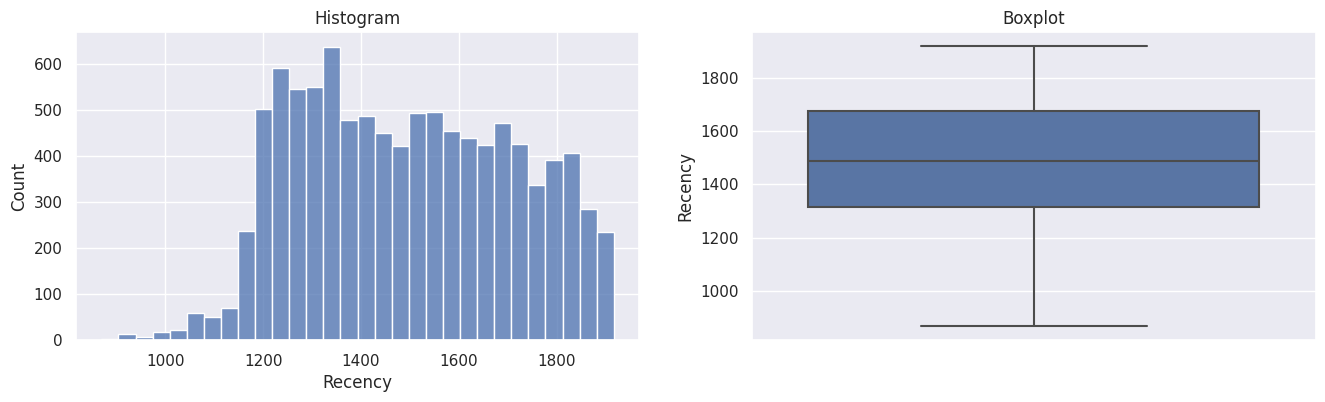

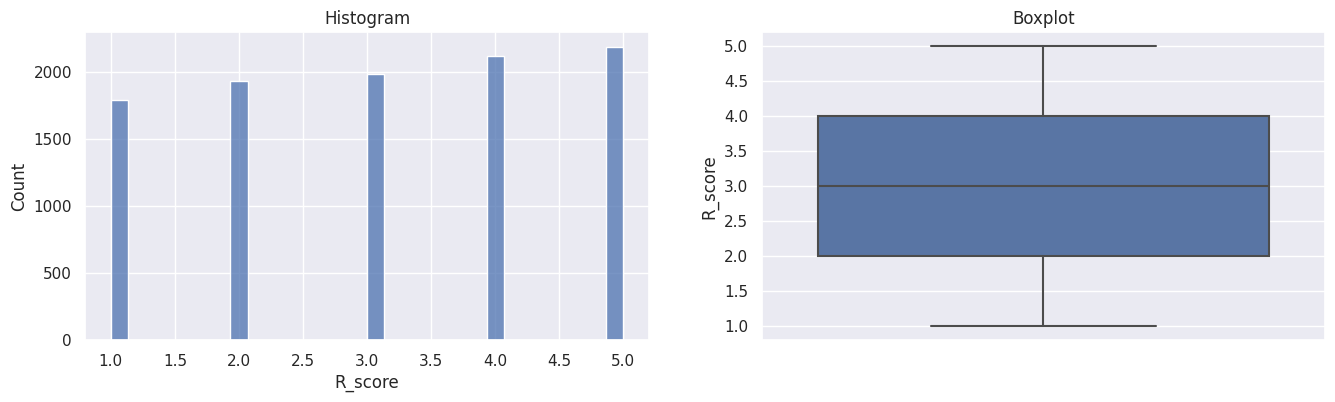

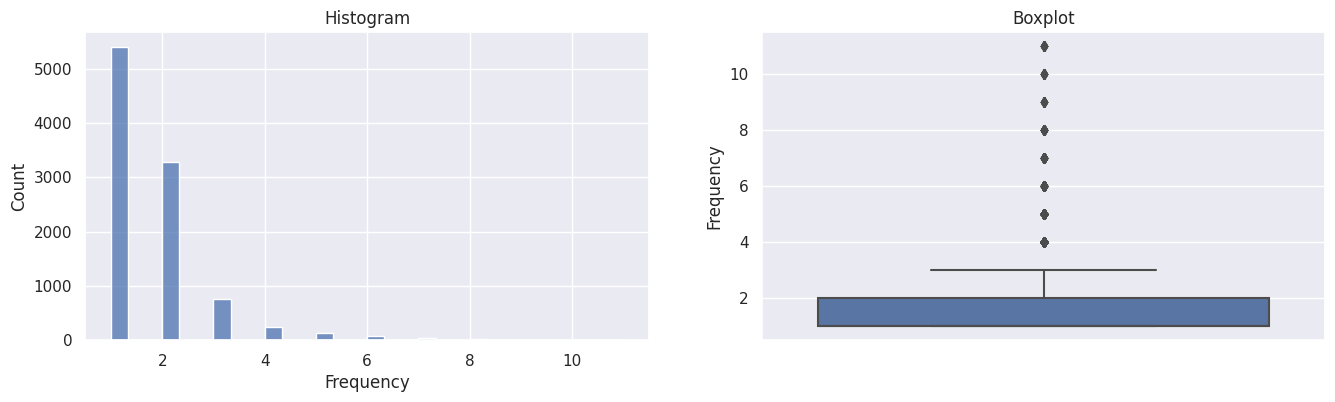

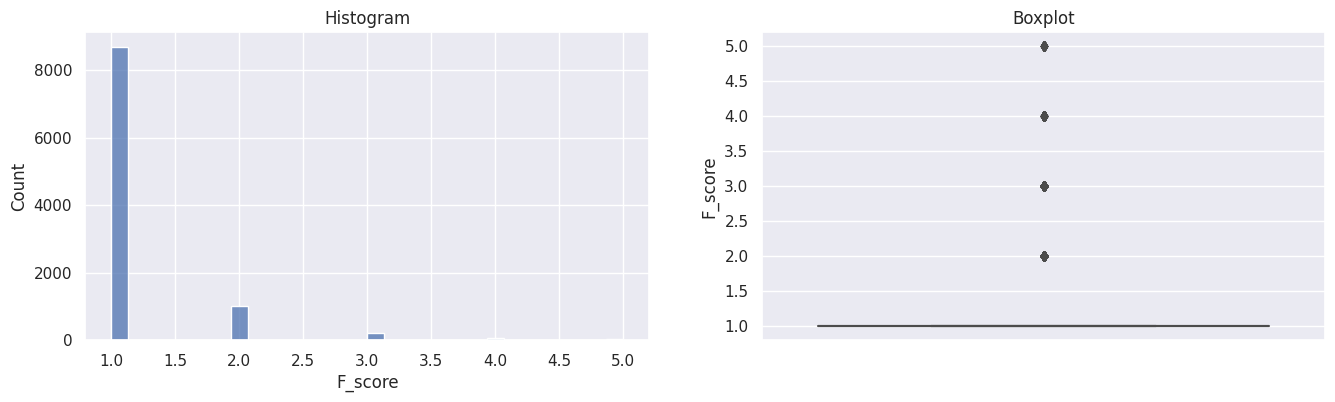

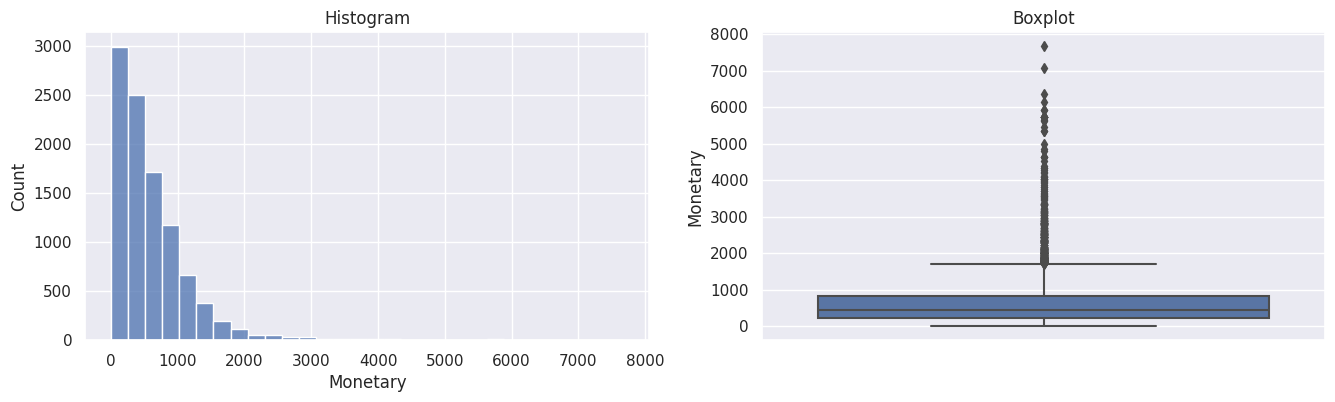

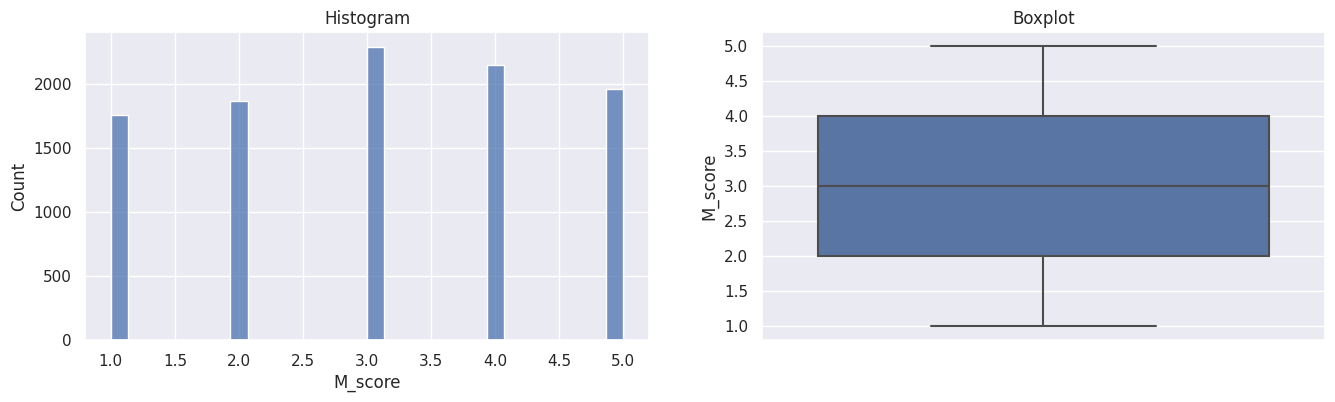

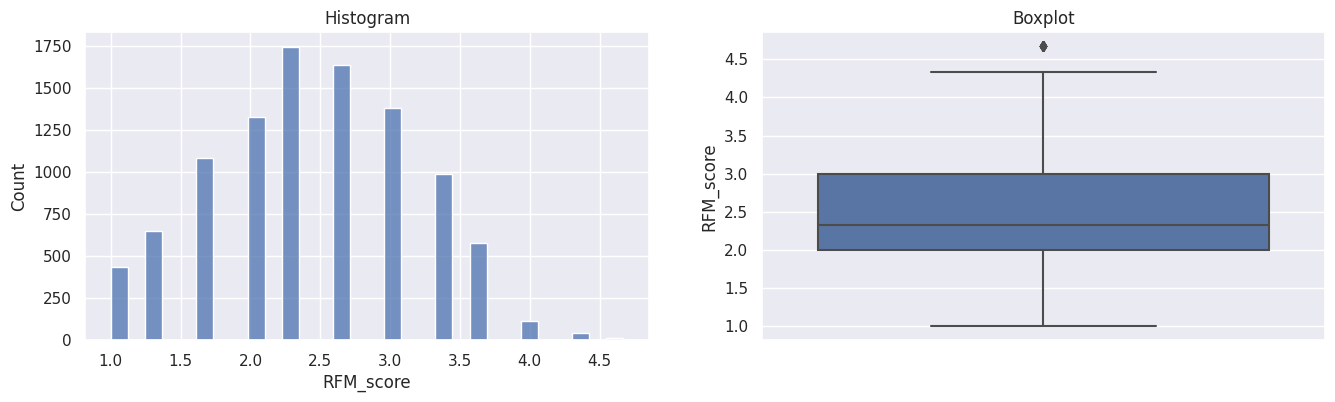

In [ ]:
# Checking the dataset for outlier
diagnostic_plots(data, 'Recency')
diagnostic_plots(data, 'R_score')
diagnostic_plots(data, 'Frequency')
diagnostic_plots(data, 'F_score')
diagnostic_plots(data, 'Monetary')
diagnostic_plots(data, 'M_score')
diagnostic_plots(data, 'RFM_score')


There are outlir found in the Frequency and Monetary column. Since both of those columns have skewed distribution to handle the outliers we are going to use winsorizer with iqr capping method.

In [ ]:
# Capping the outlier with iqr
winsorizer = Winsorizer(capping_method='iqr', tail='both', fold=3, 
                        variables=['Monetary', 'Frequency'])

winsorizer.fit(data)

X_train_cap = winsorizer.transform(data)

## Feature Selection

Since we are going to use RFM model as the basis for calculating customer lifetime values the variable that we are going to use as aclustering are the RFM variable.

In [ ]:
# Defining data train with the RFM variable as feature
feature = ['Recency', 'R_score', 'Frequency', 'F_score', 'Monetary', 'M_score', 'RFM_score']
data_train = data[feature].copy()
data_train.head()

,Recency,R_score,Frequency,F_score,Monetary,M_score,RFM_score
0,1663,2,1,1,2309.93,5,2.67
1,1726,2,2,1,413.88,3,2.00
2,1905,1,1,1,542.59,3,1.67
3,1871,1,1,1,1134.29,5,2.33
4,1913,1,1,1,140.59,1,1.00


## Feature Scalling

In [ ]:
# Scale the variable with MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(data_train)
data_final = scaler.fit_transform(data_train)

## Dimension Reduction

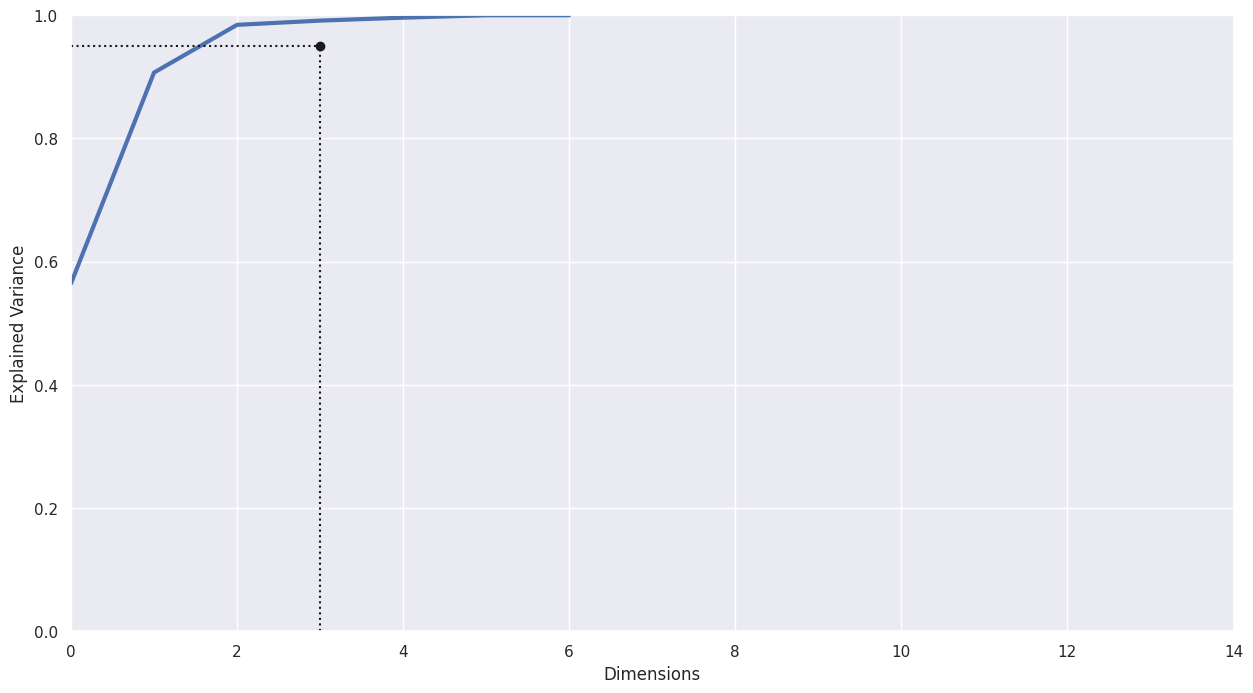

In [ ]:
# Dimensionality reduction with PCA
pca = PCA()
pca.fit(data_final)

cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

plt.figure(figsize=(15,8))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 14, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.grid(True)
plt.show()


<Axes: >

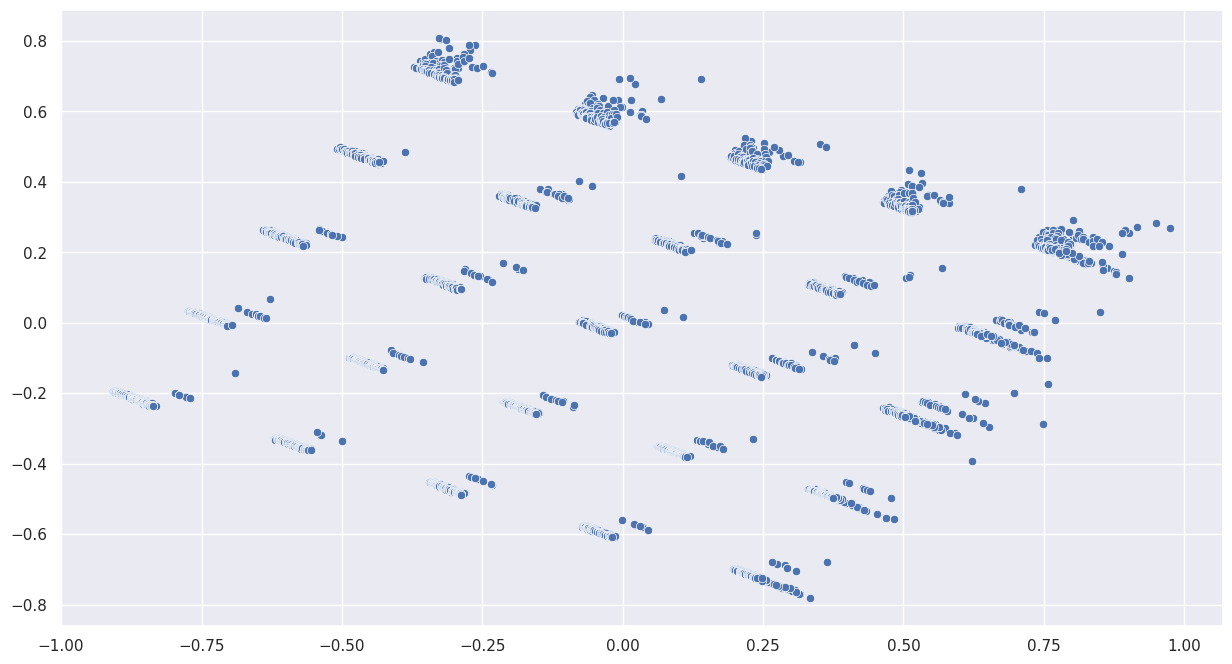

In [ ]:
# Visualization of PCA with 3 components
pca_red = PCA(n_components=3).fit_transform(data_final)
plt.figure(figsize=(15,8))
sns.scatterplot(x=pca_red[:,0],y=pca_red[:,1])

# Model Definition

For the sake of simplicity and speed we are going to use K-Means Model as a model for our clustering

In [ ]:
kmeans = KMeans()

# Model Training

In [ ]:
kmeans.fit(data_final)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans()

# Model Evaluation

Model evaluation will be used to determine the ideal amount of cluster to be made using silhouette score methods.


In [ ]:
# Define function for evaluation and visualization with silhouette score
def plot_silhouette(model,range_n_clusters,X,model_name):
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        clusterer = model(n_clusters=n_clusters)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')


        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle((f"Silhouette analysis for {model_name} clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

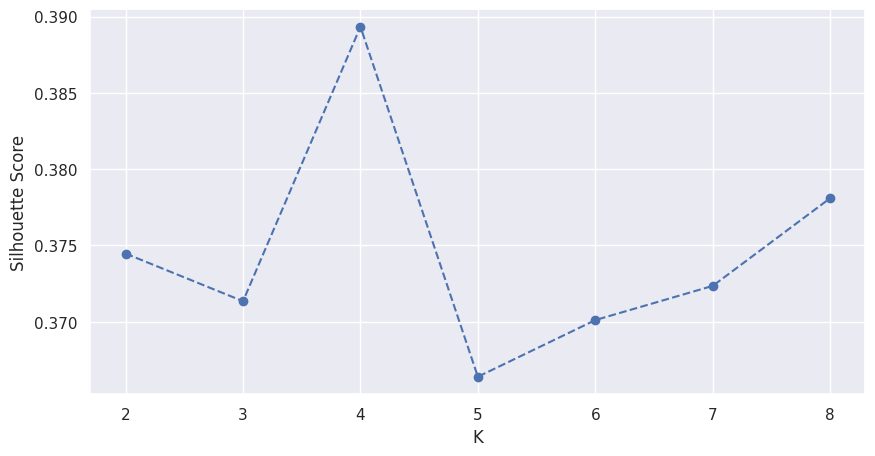

In [ ]:
# Evaluate cluster number silhouette score
K=[2,3,4,5,6,7,8]
s_score_slc=[silhouette_score(pca_red, KMeans(n_clusters=i).fit(pca_red).labels_) for i in K]
plt.figure(figsize=(10,5))
plt.plot(K,s_score_slc,'o--')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.show()

From this analysis we found that the cluster number with the highest silhouette score are 4 clusters. So from this score alone we can conclude that the ideal number of cluster is 4 cluster, but to be even more sure we need to investigate the clustering projection visualization

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 2 The average silhouette_score is : 0.3744702899906114


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 3 The average silhouette_score is : 0.3713479642420519


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 4 The average silhouette_score is : 0.38933460427323946


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 5 The average silhouette_score is : 0.3965495966103326


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 6 The average silhouette_score is : 0.3764067154752378


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 7 The average silhouette_score is : 0.36906208573326527


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 8 The average silhouette_score is : 0.37020132921335996


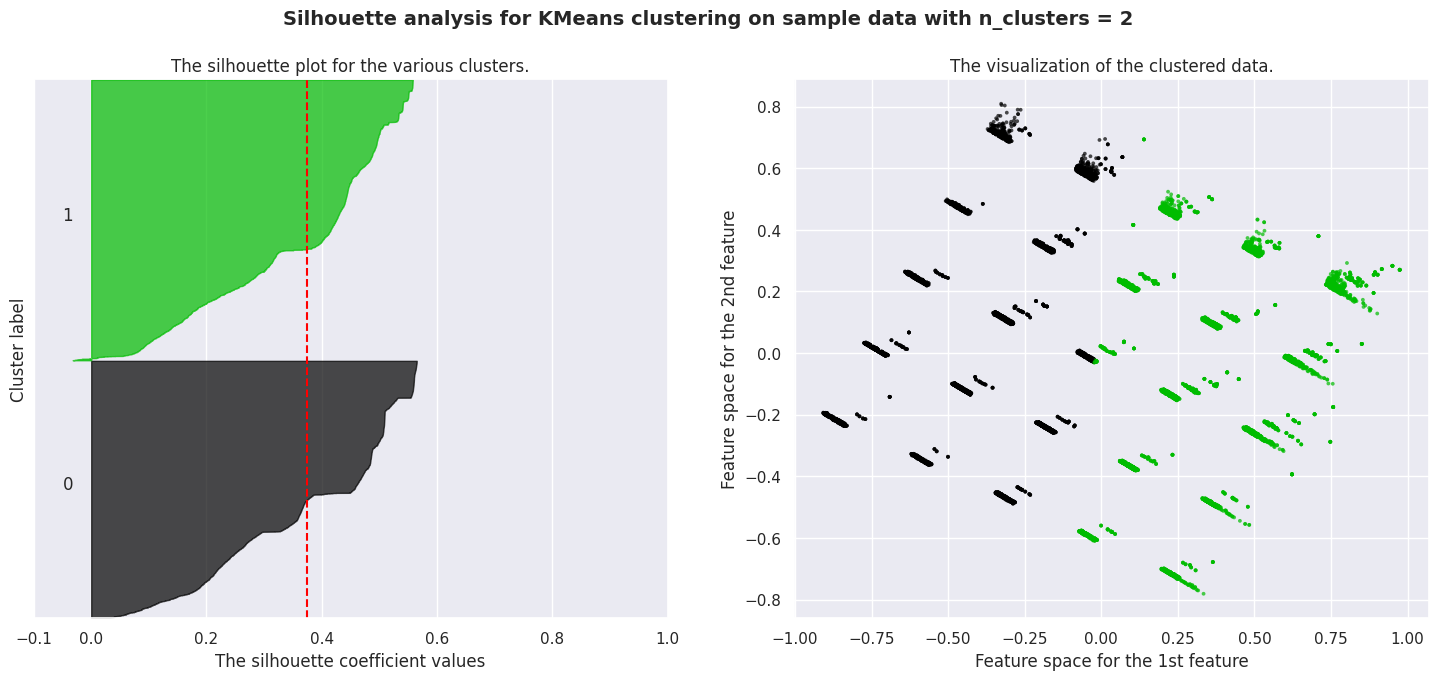

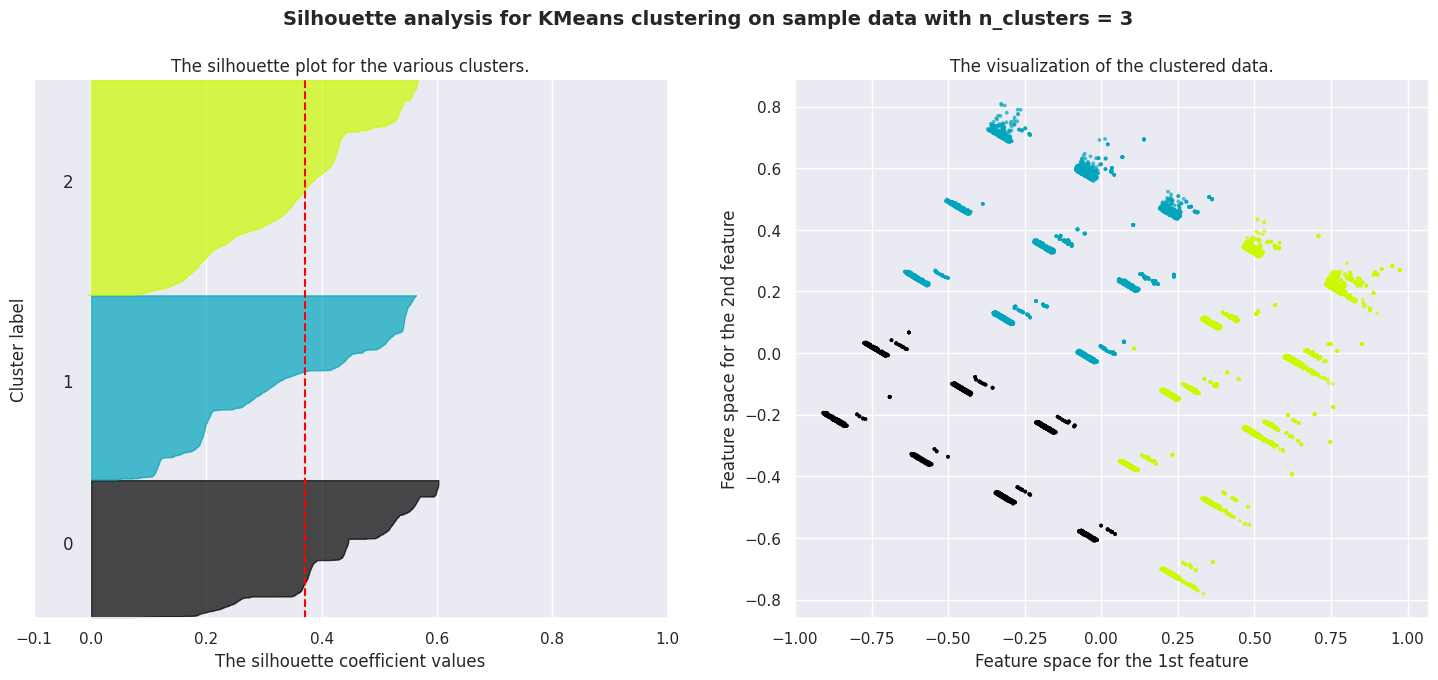

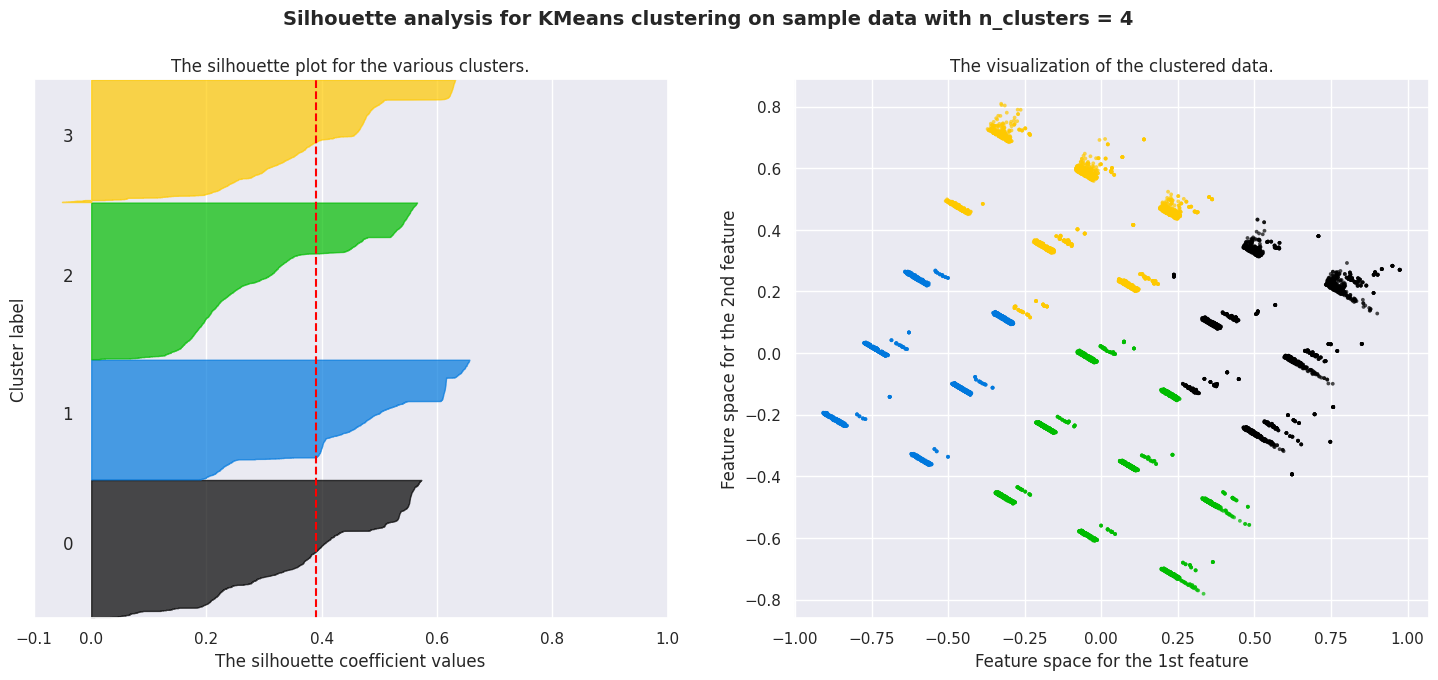

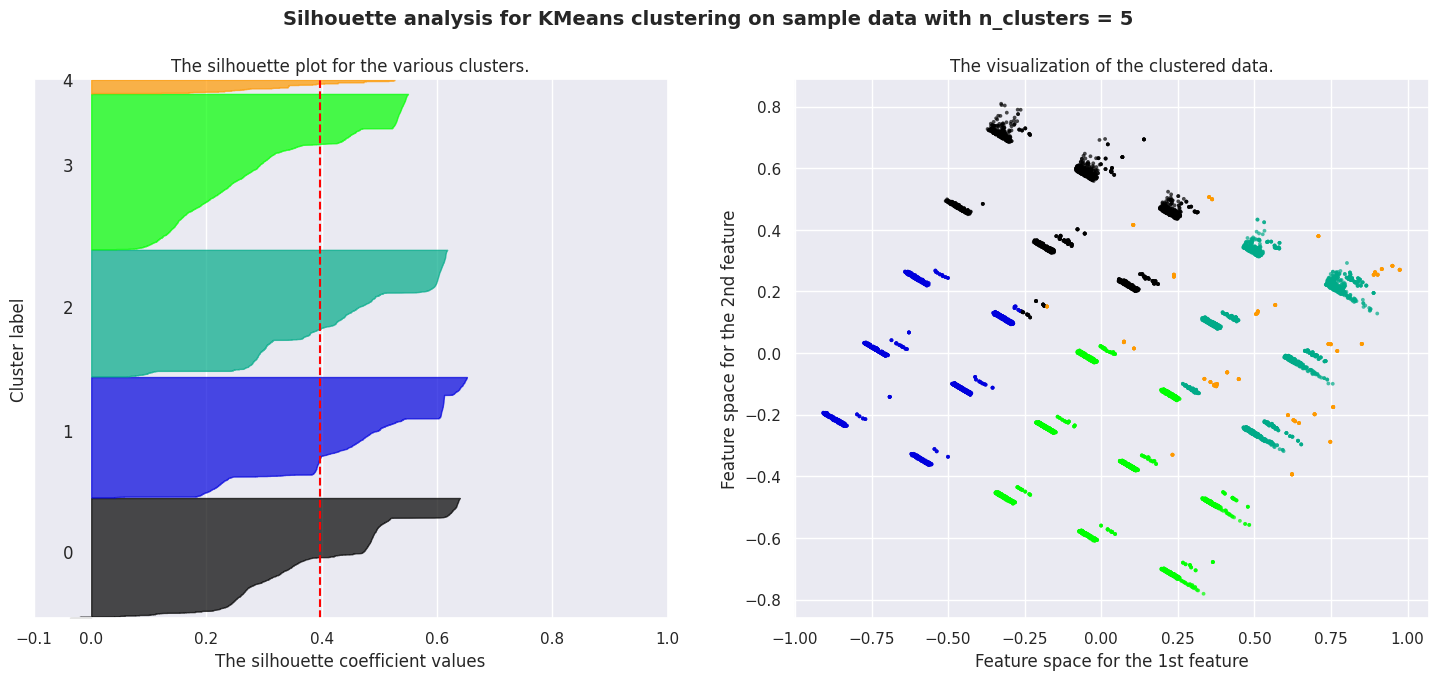

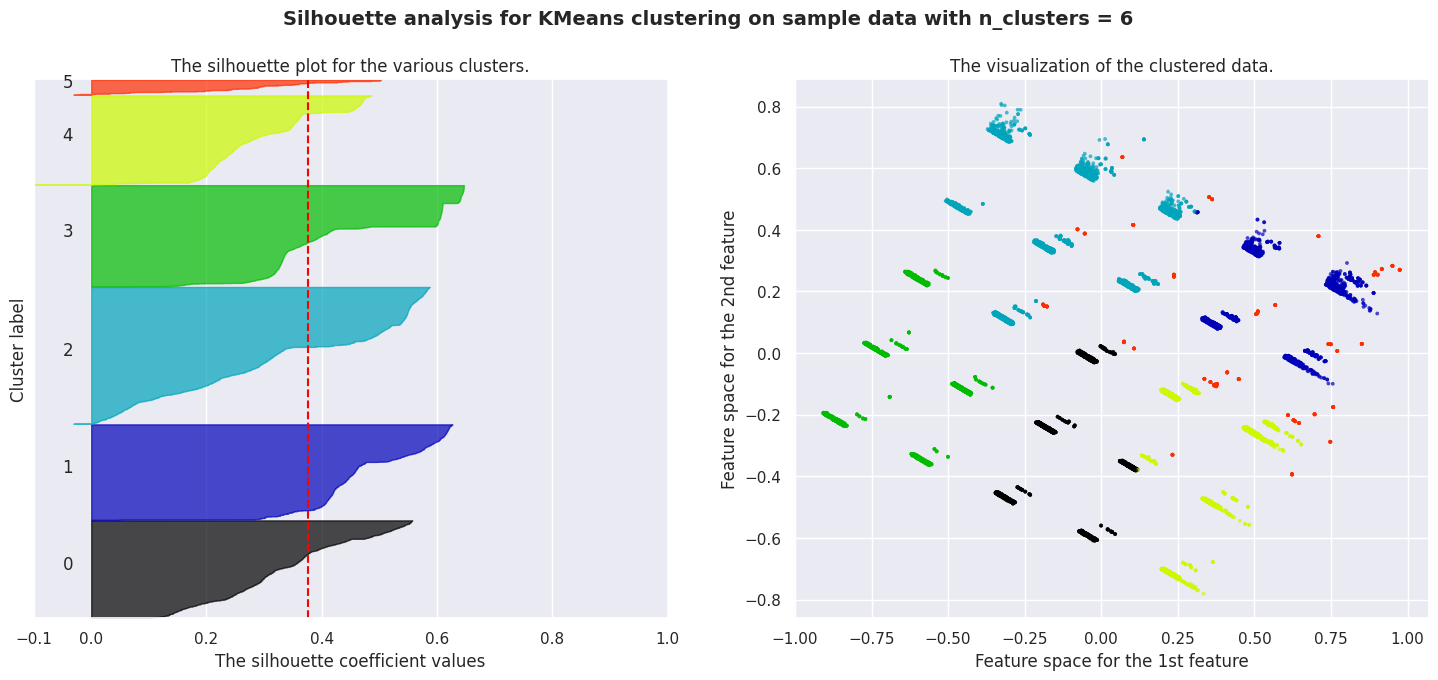

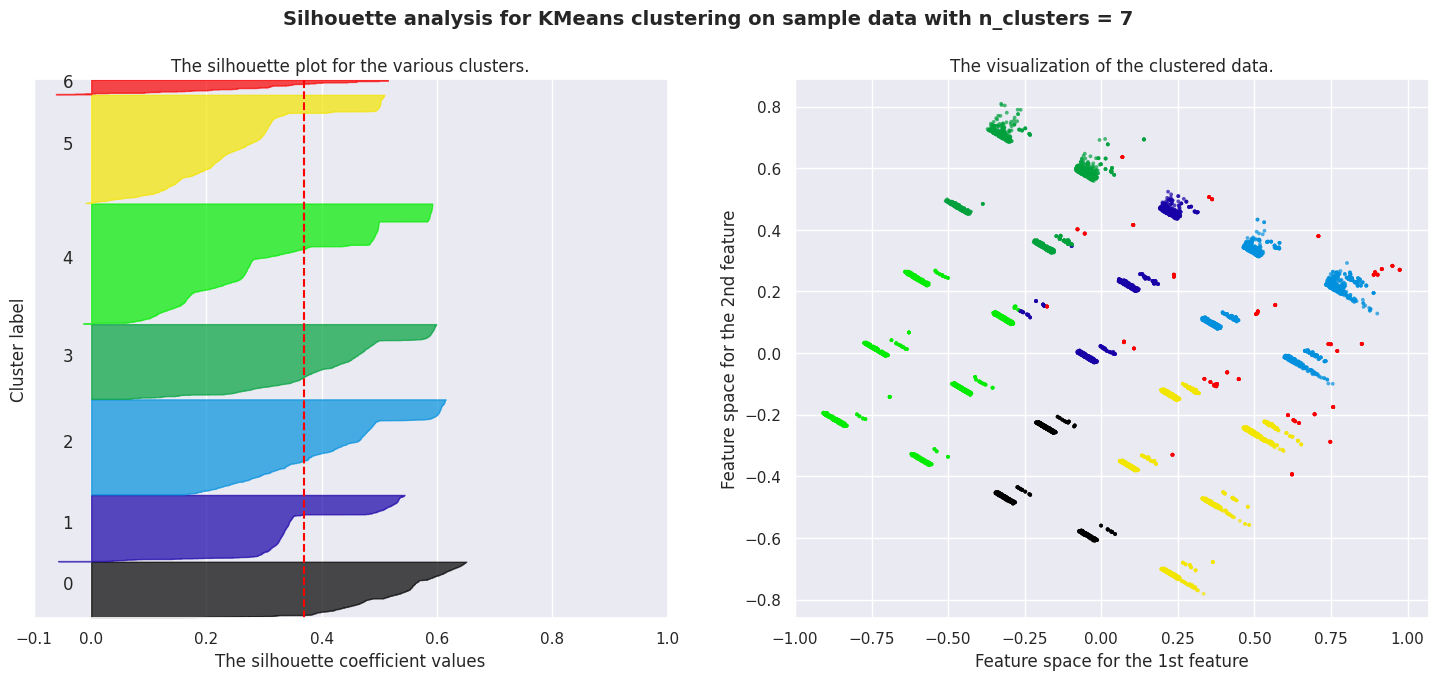

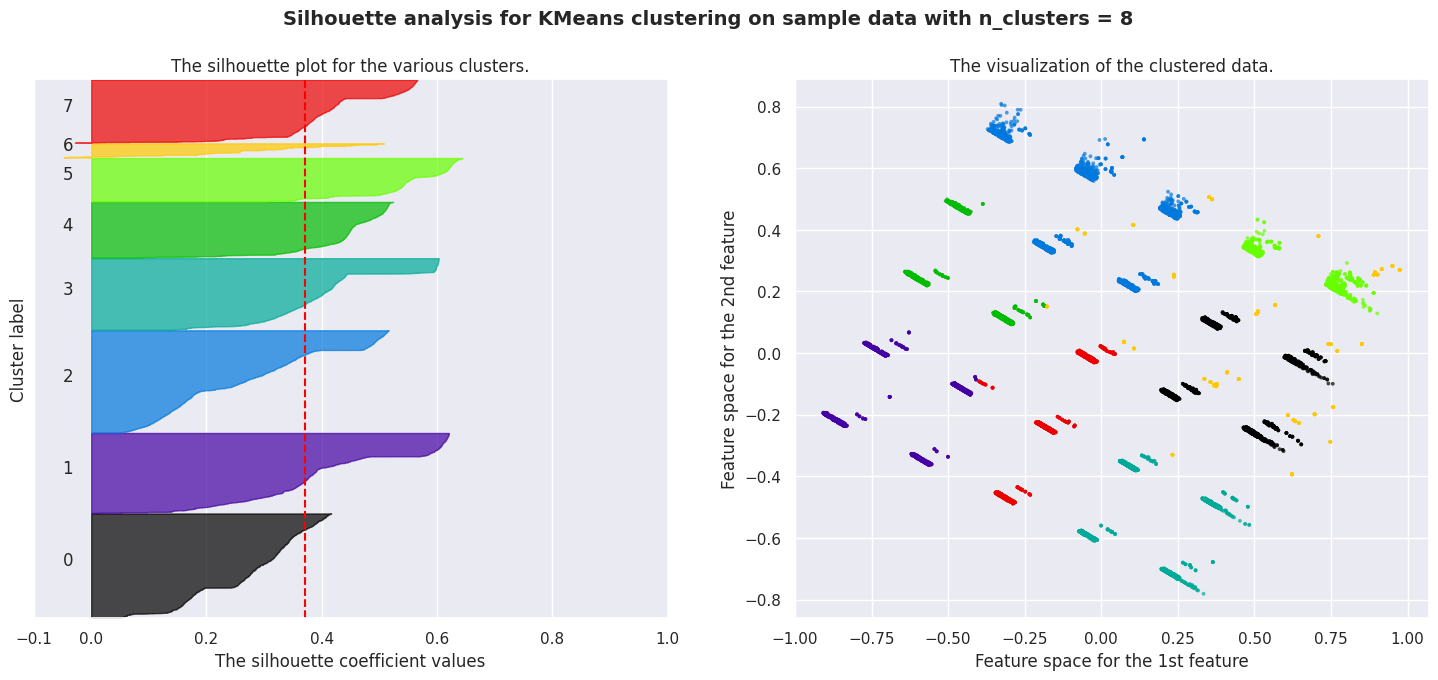

In [ ]:
# Visualizing each each cluster number projection
plot_silhouette(KMeans,K,pca_red,'KMeans')

From these projection we can see that the least overlap found in the 3 cluster number, so we are going to make clustering model that make 3 different cluster.

In [ ]:
# Seting model KMeans make 2 cluster
kmeans_tune = KMeans(n_clusters=3, random_state=50)
kmeans_tune.fit(pca_red)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3, random_state=50)

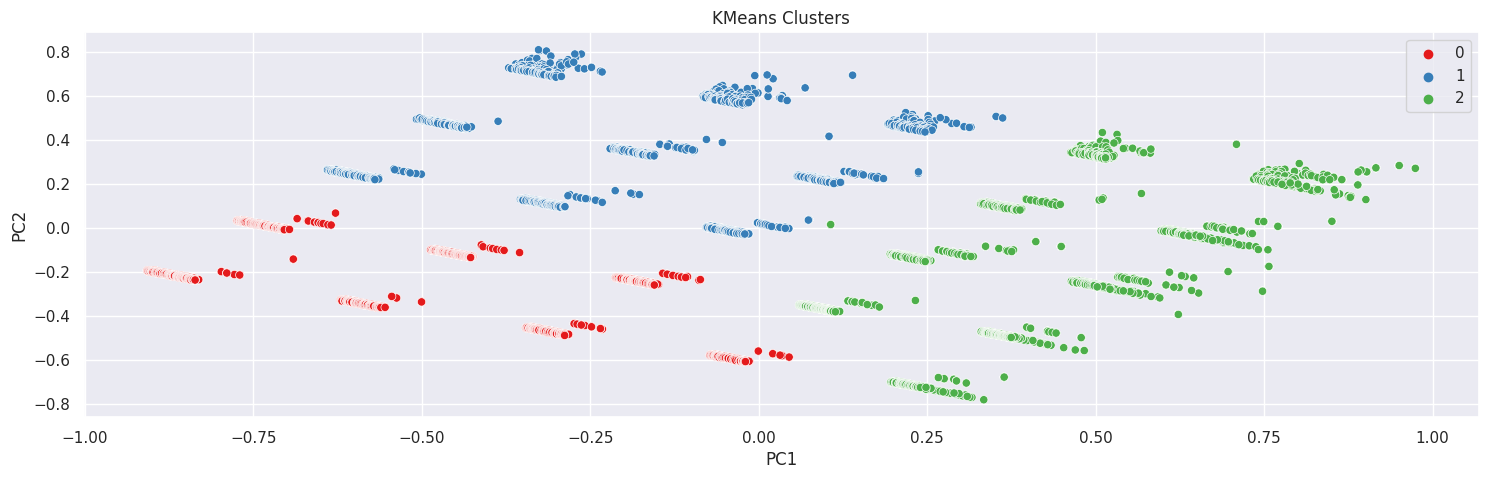

In [ ]:
# Visualization of cluster result
plt.figure(figsize=(18, 5))
sns.scatterplot(x=pca_red[:, 0], y=pca_red[:, 1], hue=kmeans_tune.labels_, palette='Set1')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('KMeans Clusters')
plt.show()

In [ ]:
# Adding cluster result to main dataframe
data['Cluster'] = kmeans_tune.fit_predict(pca_red)
data

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,GuestID,Status,RoomGroupID,CreatedDate,ArrivalDate,DepartureDate,RoomPrice,Channel,RoomNo,Country,...,Children,TotalPayment,Recency,R_score,Frequency,F_score,Monetary,M_score,RFM_score,Cluster
0,53801,O,1,2017-12-19,2018-09-09,2018-09-19,230.89,other,467.0,au,...,0,2309.93,1663,2,1,1,2309.930000,5,2.67,1
1,37129,O,1,2017-12-20,2018-01-03,2018-01-05,170.15,other,467.0,us,...,0,340.94,1726,2,2,1,413.880000,3,2.00,1
2,37708,O,1,2017-12-20,2018-01-17,2018-01-20,176.81,other,647.0,jp,...,0,542.59,1905,1,1,1,542.590000,3,1.67,1
3,41515,O,1,2017-12-20,2018-02-18,2018-02-23,226.80,other,508.0,gb,...,0,1134.29,1871,1,1,1,1134.290000,5,2.33,1
4,37390,O,1,2017-12-21,2018-01-11,2018-01-12,129.80,offline,529.0,cn,...,0,140.59,1913,1,1,1,140.590000,1,1.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,131389,O,1,2020-01-10,2020-01-13,2020-01-19,217.08,offline,625.0,il,...,0,1306.40,1176,5,3,2,1226.380000,5,4.00,2
9996,195075,O,1,2020-01-11,2020-01-14,2020-01-15,205.33,other,608.0,au,...,0,212.21,1180,5,3,2,238.046667,2,3.00,2
9997,37753,O,1,2020-01-11,2020-01-26,2020-01-31,219.33,other,617.0,in,...,0,1102.85,1164,5,2,1,759.445000,4,3.33,2
9998,144192,O,2,2020-01-12,2020-01-15,2020-01-16,248.16,other,456.0,ca,...,0,259.06,1179,5,1,1,259.060000,2,2.67,2


Text(0.5, 1.0, 'Cluster Proportion')

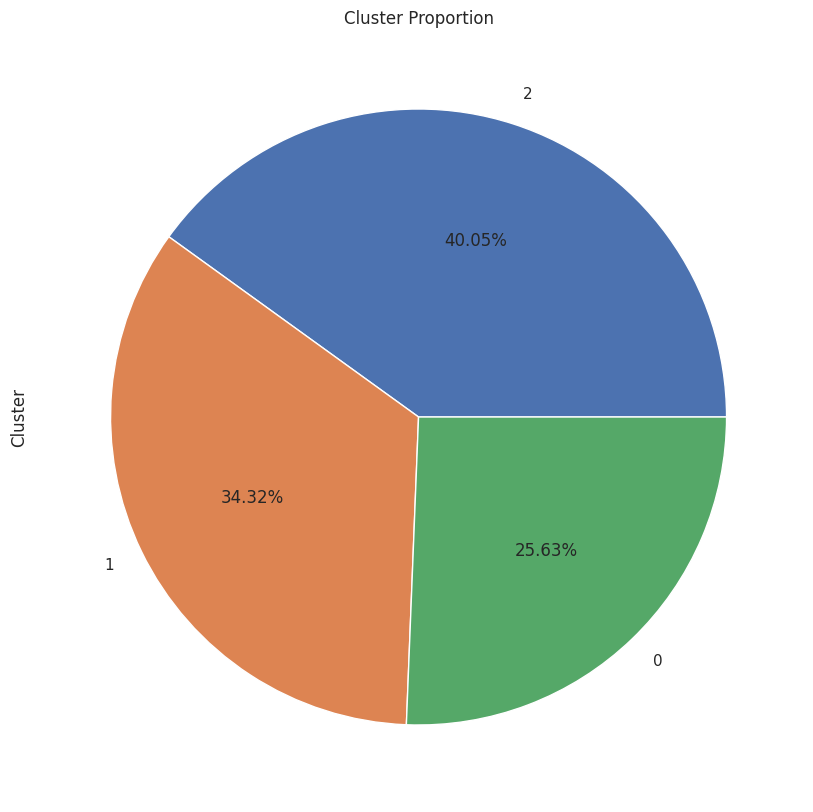

In [ ]:
# Visualization of cluster proportion
data['Cluster'].value_counts().plot(kind='pie', figsize=(10,10), autopct='%.2f%%')
plt.title('Cluster Proportion')

The model cluster result have 52.19% proportion for cluster 0 and 47.81 of cluster 1

In [ ]:
# Using descriptive statistic to evaluate each cluster characteristic
mean = np.round(data.groupby('Cluster')[feature].mean(), decimals=2)
mean

,Recency,R_score,Frequency,F_score,Monetary,M_score,RFM_score
Cluster,,,,,,,
0,1630.45,2.21,1.39,1.07,201.82,1.44,1.57
1,1646.23,2.08,1.67,1.15,880.28,3.97,2.40
2,1278.80,4.54,1.96,1.27,683.79,3.34,3.05


Looking at the result of each cluster feature mean, we can see that cluster 0 has lower recency, higher frequency and higher monetary value. In accordance to RFM Model we can conlude that cluster 0 are customer with more favorable characteristic, so we will label this cluster as high CLV. Meanwhile cluster 1 with higher recency, lower frequency and monetary value will be labeled as low CLV

In [ ]:
# Creating new CLV columns for clv label
clv_map = { 0 : 'low', 1 : 'mid', 2 : 'high'}
data['CLV'] = data['Cluster'].map(clv_map)

# Post Clustering EDA

Text(0.5, 1.0, 'Top 10 Country by CLV')

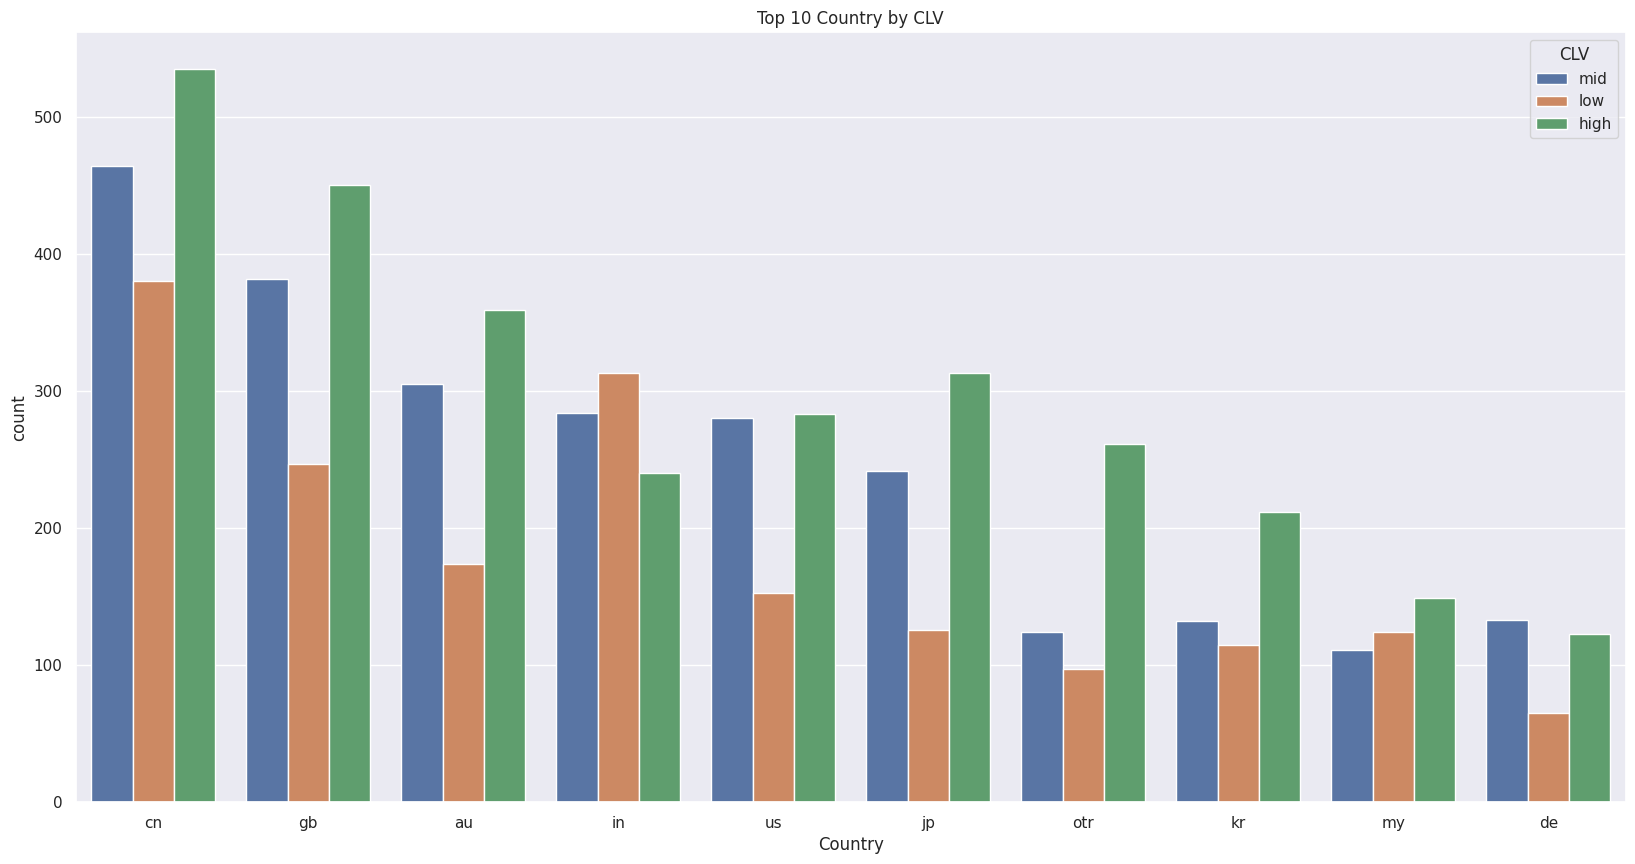

In [ ]:
sns.set()
plt.figure(figsize=(20, 10))
sns.countplot(x='Country', data=data, hue='CLV', order=data['Country'].value_counts().iloc[:10].index)
plt.title('Top 10 Country by CLV')

Text(0.5, 1.0, 'Customer who bought children by CLV')

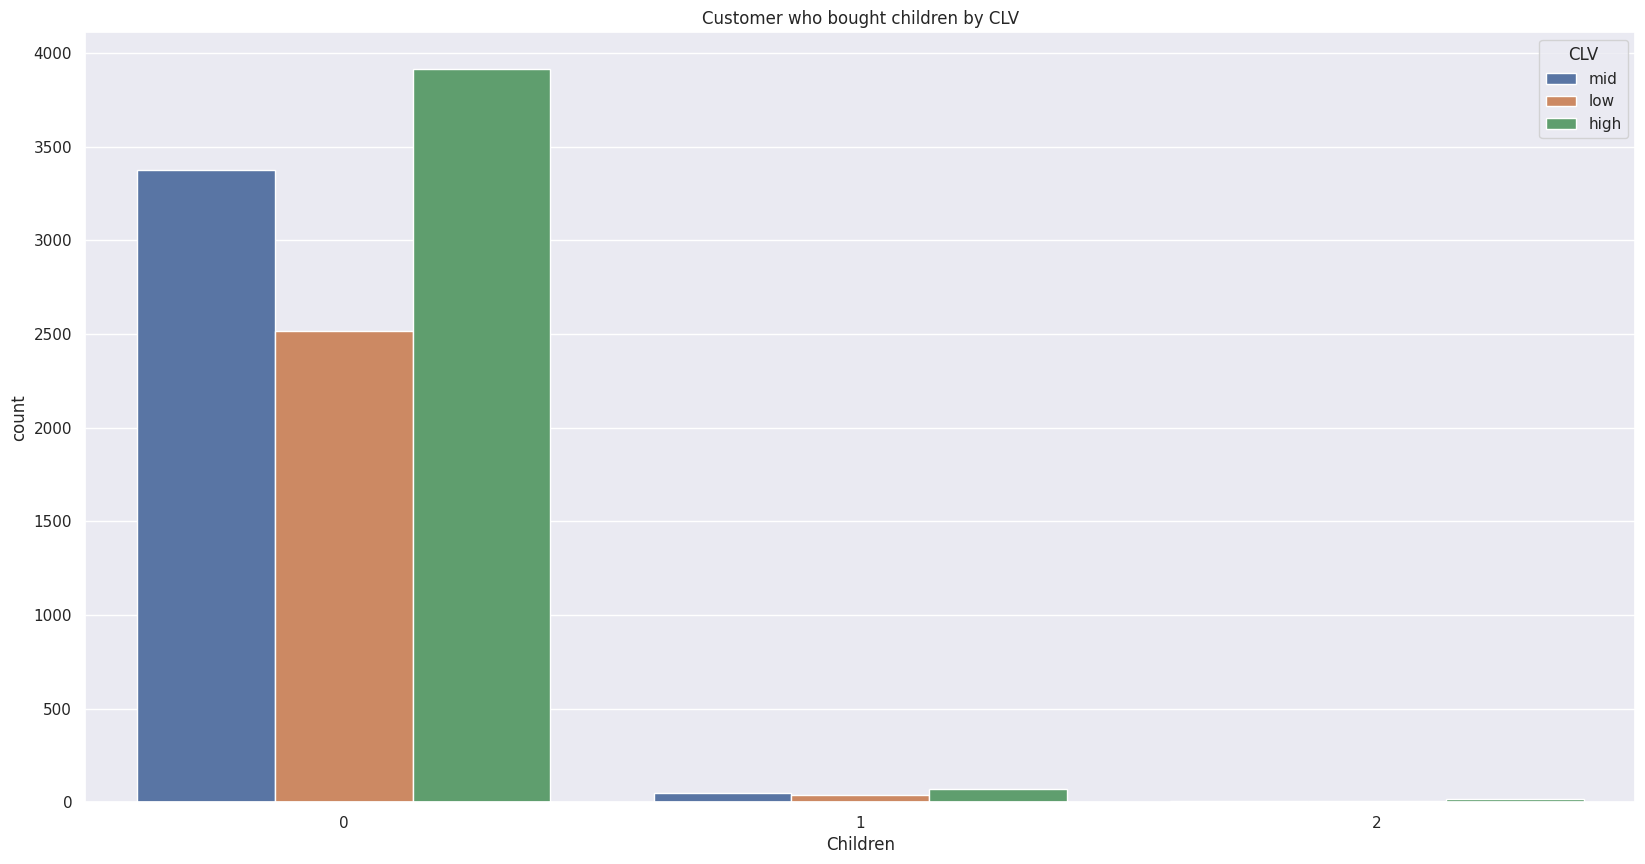

In [ ]:
plt.figure(figsize=(20, 10))
sns.countplot(x='Children', data=data, hue='CLV')
plt.title('Customer who bought children by CLV')

Text(0.5, 1.0, 'Amount of Adult per Room by CLV')

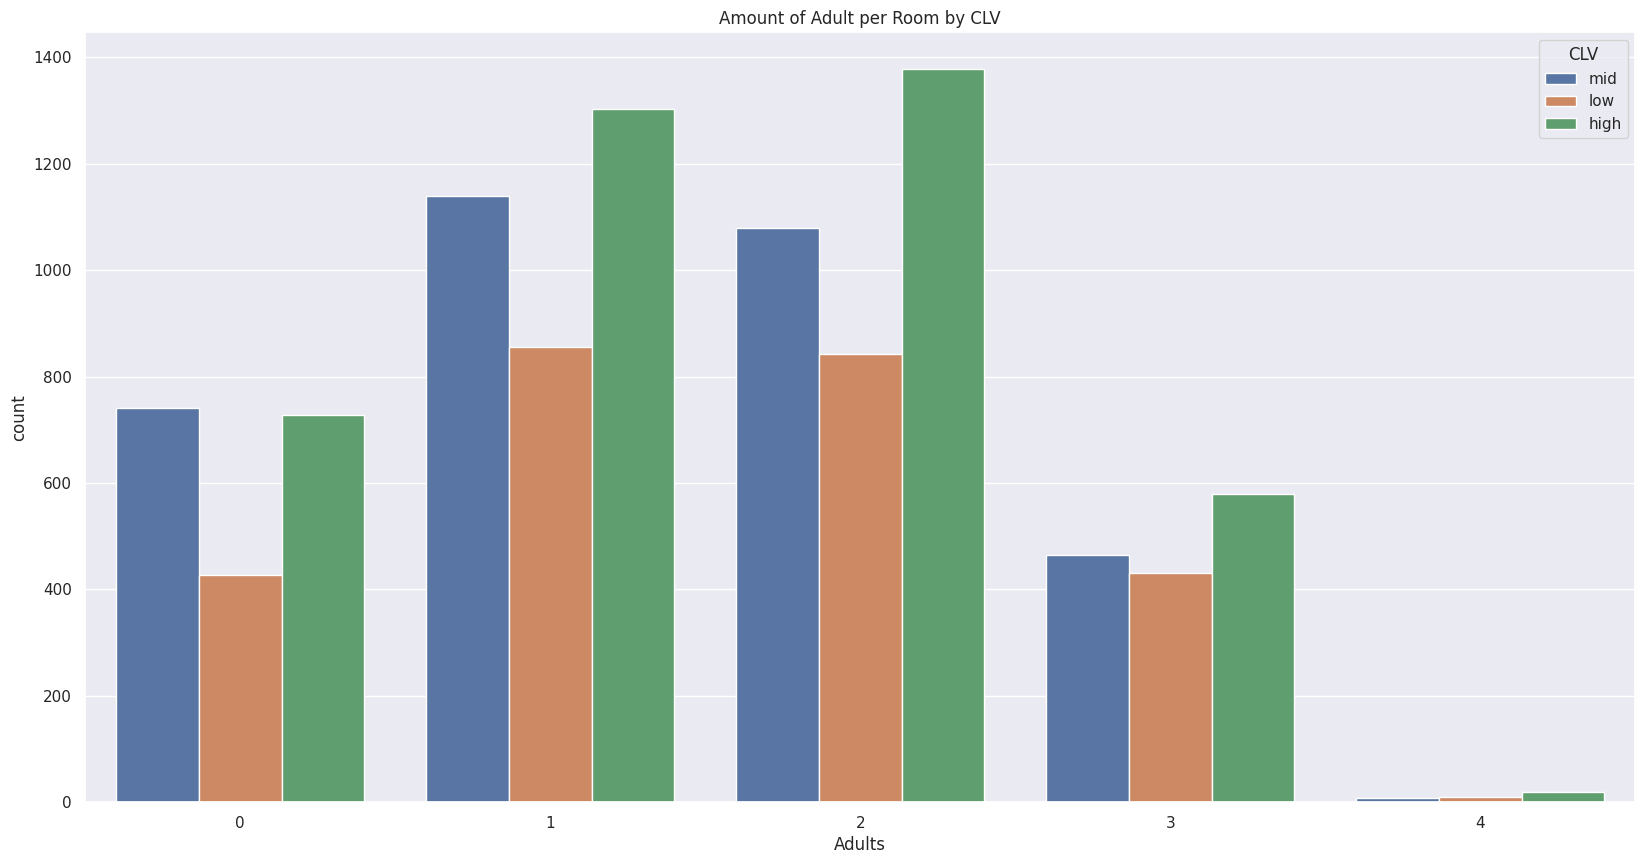

In [ ]:
plt.figure(figsize=(20, 10))
sns.countplot(x='Adults', data=data, hue='CLV')
plt.title('Amount of Adult per Room by CLV')

In [ ]:
non = data[data.Adults == 0].groupby('ArrivalDate')['Adults'].count()
single = data[data.Adults == 1].groupby('ArrivalDate')['Adults'].count()
double = data[data.Adults  == 2].groupby('ArrivalDate')['Adults'].count()
triple = data[data.Adults  == 3].groupby('ArrivalDate')['Adults'].count()
quad = data[data.Adults  == 4].groupby('ArrivalDate')['Adults'].count()

print("Average of non",non.mean())
print("Average of single",single.mean())
print("Average of double",double.mean())
print("Average of triple",triple.mean())
print("Average of quad",quad.mean())

Average of non 2.6713681241184766
Average of single 4.095652173913043
Average of double 4.094292803970223
Average of triple 2.1535087719298245
Average of quad 1.0285714285714285


In [ ]:
f_stat_adult,p_value_adult = stats.f_oneway(non, single, double, triple, quad)
print('P-value:', p_value_adult)

P-value: 5.749033978310398e-137


Text(0.5, 1.0, 'Channel of Booking by CLV')

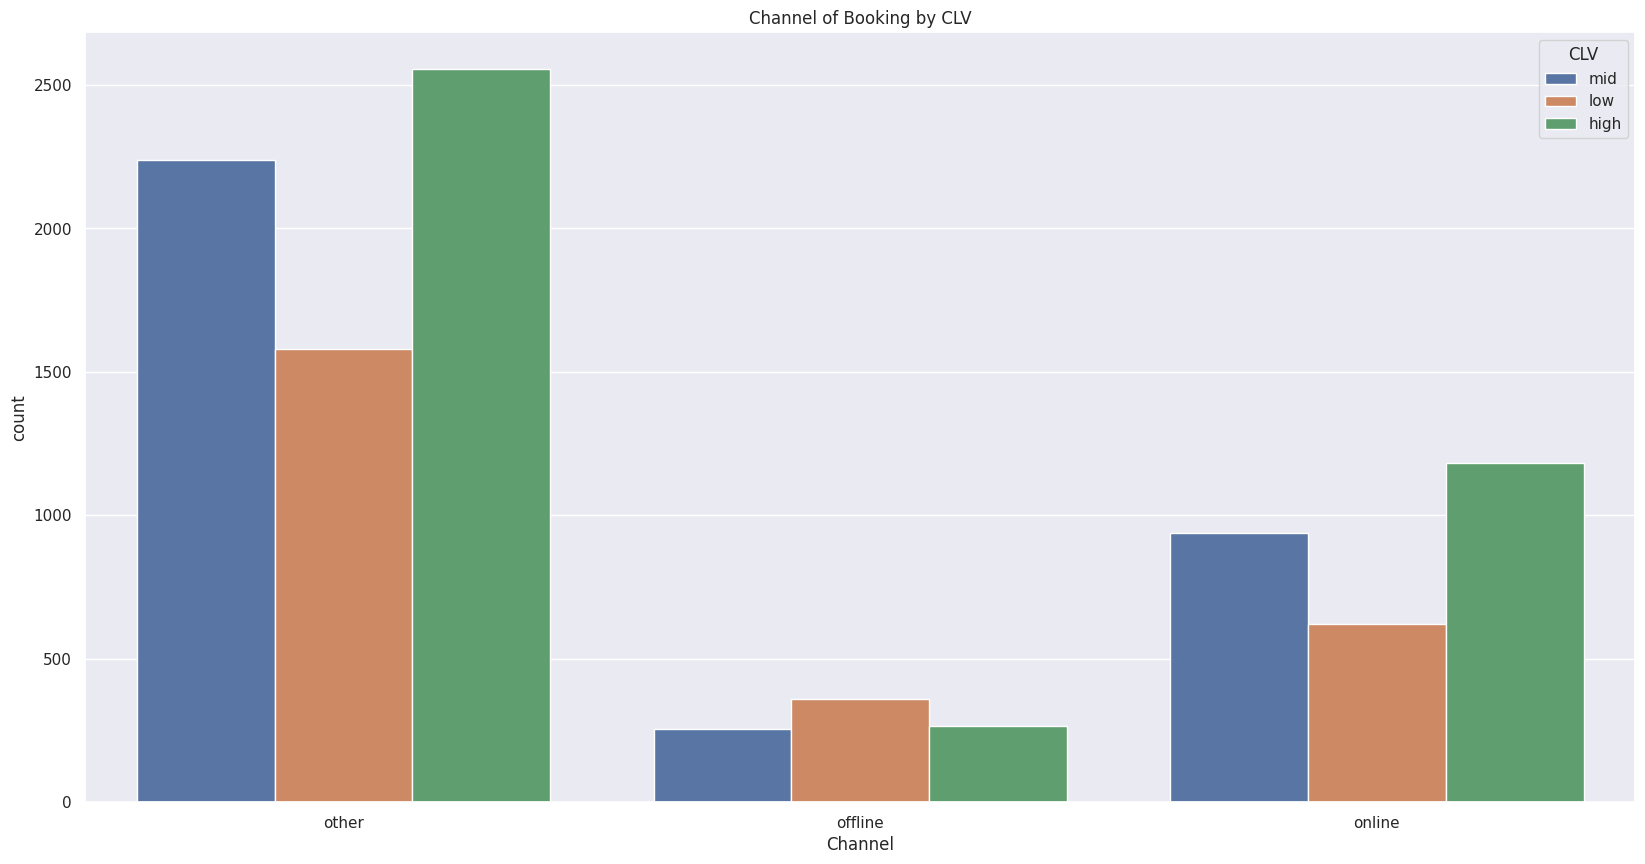

In [ ]:
plt.figure(figsize=(20, 10))
sns.countplot(x='Channel', data=data, hue='CLV')
plt.title('Channel of Booking by CLV')

In [ ]:
other = data[data.Channel == 'other'].groupby('ArrivalDate')['Channel'].count()
offline = data[data.Channel == 'offline'].groupby('ArrivalDate')['Channel'].count()
online = data[data.Channel == 'online'].groupby('ArrivalDate')['Channel'].count()

print("Average of other channel",other.mean())
print("Average of offline channel",offline.mean())
print("Average of online channel",online.mean())

Average of other channel 7.615292712066906
Average of offline channel 1.88272921108742
Average of online channel 3.403225806451613


In [ ]:
f_stat_channel,p_value_channel = stats.f_oneway(other, offline, online)
print('P-value:', p_value_channel)

P-value: 1.8792615819629785e-295


Text(0.5, 1.0, 'Average Payments by CLV')

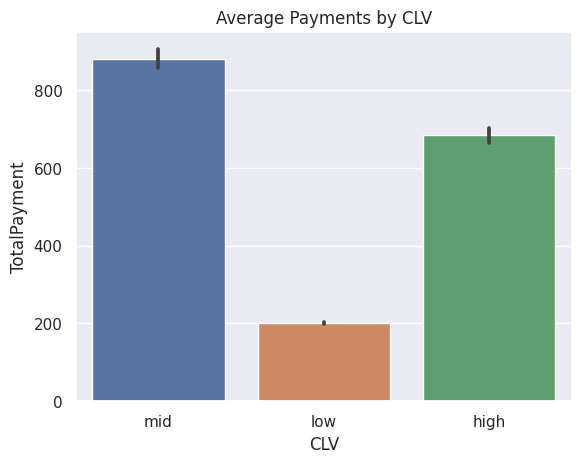

In [ ]:
sns.barplot(x='CLV', y='TotalPayment', data=data)
plt.title('Average Payments by CLV')

In [ ]:
high = data[data.CLV == 'high'].groupby('ArrivalDate')['TotalPayment'].sum()
mid = data[data.CLV == 'mid'].groupby('ArrivalDate')['TotalPayment'].sum()
low = data[data.CLV == 'low'].groupby('ArrivalDate')['TotalPayment'].sum()

print("Average of high CLV payment",high.mean())
print("Average of mid CLV payment",mid.mean())
print("Average of low CLV payment",low.mean())

Average of high CLV payment 3756.644705075446
Average of mid CLV payment 6165.5667959183675
Average of low CLV payment 873.766570945946


In [ ]:
f_stat_pay,p_value_pay = stats.f_oneway(high, mid, low)
print('P-value:', p_value_pay)

P-value: 1.0487041439208039e-146


The resullt of our hypothesis testing with ANOVA shows that the p-value < 0.05, therefore H0 is rejected. We conclude that there are significant difference between low, mid and high clv

# Conclusion

1. The clustering model with K-Means unsupervised model resulted with 3 different
cluster :
  * Low : high recency, low frequency and low monetary
  * Mid : high recency, low frequency and high monetary
  * High : low recency, low frequency and  high monetary
2. Half of the top 10 most popular customer country of origin are Asian countries. Three of them are east asian. The hotel need to invest in catering more Asian oriented customer such as their language service or other cultural specific needs.
3. Most of the customer didn’t bring children with them, so we can conclude that investing in child oriented service isn’t a priority.
4. Majority of the customer come alone or in pair. Hypothesis testing with ANOVA also shown a significant difference of mean from each category with p< 0,05. Since most of the customer are coming alone or in pair the hotel doesn’t really need to invest on a bigger room service and just focus on the single and double room service.
5. Other channel are significantly found to be difference than other type of channel in being the most popular channel to book the hotel. We can conclude that the hotel need to invest more in this other channel such as joint collaboration third party channel to increase the likelihood of a customer booking.
6. Customer with mid clv shown to have significantly more payments than other clv customer proven with hypothesis testing using ANOVA with p < 0,05, so focusing more on the customer retention program with mid clv will surely bring more profit.
7. Since most of the customers from the Hotel are book one stay only and not a repeat customer the clustering model might be biased with the low frequency customer. It might be wise for future modeling to separate repeated customer with the one time only customer in creating the clustering model.
